In [1]:
import torch

import triton
import triton.language as tl

DEVICE = triton.runtime.driver.active.get_active_torch_device()


@triton.jit
def add_kernel(x_ptr,  # *Pointer* to first input vector.
               y_ptr,  # *Pointer* to second input vector.
               output_ptr,  # *Pointer* to output vector.
               n_elements,  # Size of the vector.
               BLOCK_SIZE: tl.constexpr,  # Number of elements each program should process.
               # NOTE: `constexpr` so it can be used as a shape value.
               ):
    # There are multiple 'programs' processing different data. We identify which program
    # we are here:
    pid = tl.program_id(axis=0)  # We use a 1D launch grid so axis is 0.
    # This program will process inputs that are offset from the initial data.
    # For instance, if you had a vector of length 256 and block_size of 64, the programs
    # would each access the elements [0:64, 64:128, 128:192, 192:256].
    # Note that offsets is a list of pointers:
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    # Create a mask to guard memory operations against out-of-bounds accesses.
    mask = offsets < n_elements
    # Load x and y from DRAM, masking out any extra elements in case the input is not a
    # multiple of the block size.
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    # Write x + y back to DRAM.
    tl.store(output_ptr + offsets, output, mask=mask)

In [2]:
def triton_add(x: torch.Tensor, y: torch.Tensor):
    # We need to preallocate the output.
    output = torch.empty_like(x)
    assert x.device == DEVICE and y.device == DEVICE and output.device == DEVICE
    n_elements = output.numel()
    # The SPMD launch grid denotes the number of kernel instances that run in parallel.
    # It is analogous to CUDA launch grids. It can be either Tuple[int], or Callable(metaparameters) -> Tuple[int].
    # In this case, we use a 1D grid where the size is the number of blocks:
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']), )
    # NOTE:
    #  - Each torch.tensor object is implicitly converted into a pointer to its first element.
    #  - `triton.jit`'ed functions can be indexed with a launch grid to obtain a callable GPU kernel.
    #  - Don't forget to pass meta-parameters as keywords arguments.
    triton_kernel=add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    # torch.cuda.synchronize()
    # print(triton_kernel.asm['ptx'])
    # We return a handle to z but, since `torch.cuda.synchronize()` hasn't been called, the kernel is still
    # running asynchronously at this point.
    return output

In [3]:
size=262144
x = torch.rand(size, device=DEVICE)
y = torch.rand(size, device=DEVICE)
output_torch = x + y
output_triton = triton_add(x, y)
max_diff = (output_torch - output_triton).abs().max().item()
print(f"Max difference: {max_diff}")

Max difference: 0.0


In [7]:
import os
import torch
from torch.utils.cpp_extension import load

# this_dir = os.path.dirname(__file__)

this_dir = os.getcwd()
ext = load(
  name="vector_add_ext",
  sources=[
    os.path.join(this_dir, "vector_add.cpp"),
    os.path.join(this_dir, "vector_add_kernel.cu"),
  ],
  verbose=True,
)

def cuda_add(x: torch.Tensor, y: torch.Tensor):
  return ext.add_cuda(x, y)

device = torch.device("cuda:0")
torch.manual_seed(0)

# x = torch.rand(size, device=device, dtype=torch.float32)
# y = torch.rand(size, device=device, dtype=torch.float32)

out_cuda = cuda_add(x, y)
torch.cuda.synchronize()
max_diff = (output_torch - out_cuda).abs().max().item()
print(f"Max difference: {max_diff}")

[1/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output vector_add_kernel.cuda.o.d -DTORCH_EXTENSION_NAME=vector_add_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -isystem /venv/main/lib/python3.12/site-packages/torch/include -isystem /venv/main/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /usr/local/cuda/include -isystem /venv/main/include/python3.12 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_120,code=compute_120 -gencode=arch=compute_120,code=sm_120 --compiler-options '-fPIC' -std=c++17 -c /workspace/vector_add_kernel.cu -o vector_add_kernel.cuda.o 
[2/3] c++ -MMD -MF vector_add.o.d -DTORCH_EXTENSION_NAME=vector_add_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -isystem /venv/main/lib/python3.12/site-packages/torch/include -isystem /venv/main/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -i

In [5]:
# This decorator sets up a comprehensive performance comparison across different implementations

@triton.testing.perf_report(
    triton.testing.Benchmark(
        # X-axis configuration: the independent variable we're testing
        x_names=['size'],  # Parameter name that varies across benchmark runs
        x_vals=[2**i for i in range(12, 25, 1)],  # Test sizes from 2^8 (256) to 2^27 (134M) elements
        x_log=True,  # Use logarithmic scale for x-axis (better for exponential ranges)

        # Line configuration: compare different implementations
        line_arg='provider',  # Parameter that distinguishes different implementations
        line_vals=['triton', 'torch', 'cuda'],  # Internal identifiers for each implementation
        line_names=['Triton', 'Torch', 'cuda'],  # Display names for the legend
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # (color, line_style) tuples

        # Plot configuration
        ylabel='GB/s',  # Y-axis label (measuring memory bandwidth)
        plot_name='vector-add-performance',  # Output filename and plot title
        args={},  # Additional fixed arguments (empty here since we only vary size/provider)
    ))
    # basically, the above decorator says that I'm going to have a 2D Diagram
    # x values would be 'size' and lines would be triton, torch and cuda.
def benchmark(size, provider):
    """
    Benchmarks vector addition across three implementations: PyTorch, Triton, and CUDA.

    Args:
        size: Number of elements in the vectors
        provider: Which implementation to benchmark ('torch', 'triton', or 'cuda')

    Returns:
        Tuple of (median_gbps, min_gbps, max_gbps) representing bandwidth at different quantiles
    """
    # Create random input tensors on the specified device
    x = torch.rand(size, device=DEVICE, dtype=torch.float32)
    y = torch.rand(size, device=DEVICE, dtype=torch.float32)

    for _ in range(5):
        if provider == 'torch':
            x + y
        elif provider == 'triton':
            triton_add(x, y)
        else:
            cuda_add(x, y)
    torch.cuda.synchronize()
    # Quantiles for statistical analysis: [median, 20th percentile, 80th percentile]
    # This captures the distribution of timings across multiple runs
    quantiles = [0.5, 0.2, 0.8]

    # Benchmark each implementation
    # do_bench runs the lambda multiple times and returns timing statistics
    if provider == 'torch':
        # Native PyTorch element-wise addition
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == 'triton':
        # Custom Triton kernel implementation
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_add(x, y), quantiles=quantiles)
    if provider == 'cuda':
        # Custom CUDA kernel implementation
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: cuda_add(x, y), quantiles=quantiles)

    # Calculate memory bandwidth in GB/s
    # Formula breakdown:
    #   - 3 * x.numel(): total elements accessed (read x, read y, write output)
    #   - x.element_size(): bytes per element (4 bytes for float32)
    #   - 1e-9: convert bytes to gigabytes
    #   - (ms * 1e-3): convert milliseconds to seconds
    gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)

    # Return bandwidth for median, fastest (max_ms → min bandwidth), and slowest (min_ms → max bandwidth)
    # Note: max_ms gives min bandwidth and vice versa
    return gbps(ms), gbps(max_ms), gbps(min_ms)

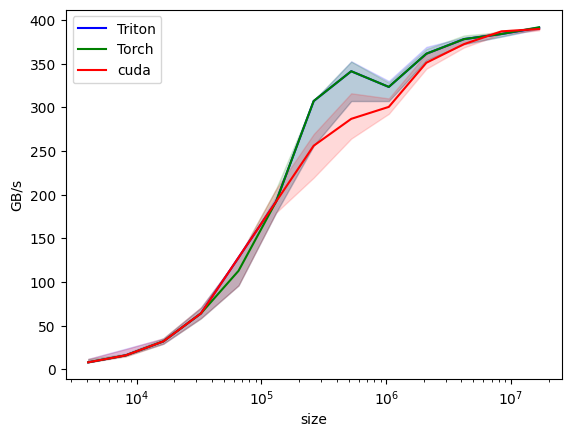

vector-add-performance:
          size      Triton       Torch        cuda
0       4096.0    8.000000    8.000000    8.000000
1       8192.0   15.999999   15.999999   15.999999
2      16384.0   31.999999   31.999999   31.999999
3      32768.0   63.999998   63.999998   63.999998
4      65536.0  127.999995  112.733944  127.999995
5     131072.0  192.000000  192.000000  192.000000
6     262144.0  307.200008  307.200008  255.999991
7     524288.0  341.333321  341.333321  286.809636
8    1048576.0  323.368435  323.368435  300.508991
9    2097152.0  361.411758  361.411758  351.085705
10   4194304.0  378.092307  378.092307  372.363633
11   8388608.0  384.000001  384.000001  387.023602
12  16777216.0  391.211044  391.649417  389.660338


In [68]:
benchmark.run(print_data=True, show_plots=True)

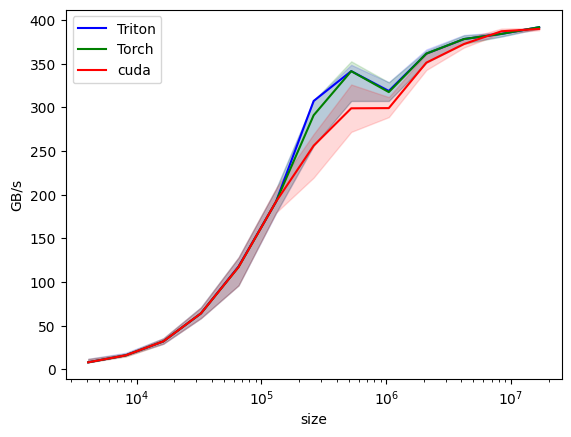

vector-add-performance:
          size      Triton       Torch        cuda
0       4096.0    8.041885    8.000000    8.000000
1       8192.0   15.999999   15.999999   15.999999
2      16384.0   31.999999   31.999999   31.999999
3      32768.0   63.999998   63.999998   63.999998
4      65536.0  117.588514  117.028572  117.028572
5     131072.0  192.000000  192.000000  192.000000
6     262144.0  307.200008  290.840226  255.999991
7     524288.0  341.333321  341.333321  298.796351
8    1048576.0  318.651548  317.365616  299.023574
9    2097152.0  361.411758  361.411758  351.085705
10   4194304.0  378.092307  378.092307  372.363633
11   8388608.0  384.000001  384.000001  387.023602
12  16777216.0  391.649417  391.649417  389.636200


In [70]:
benchmark.run(print_data=True, show_plots=True)

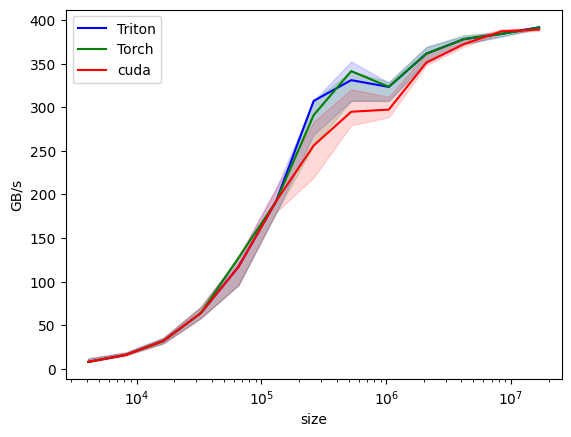

vector-add-performance:
          size      Triton       Torch        cuda
0       4096.0    8.000000    8.000000    8.000000
1       8192.0   15.999999   15.999999   15.999999
2      16384.0   31.999999   31.999999   31.999999
3      32768.0   63.999998   63.999998   63.999998
4      65536.0  117.028572  127.336788  117.028572
5     131072.0  192.000000  192.000000  192.000000
6     262144.0  307.200008  290.840226  255.999991
7     524288.0  330.989909  341.333321  294.764611
8    1048576.0  323.235525  323.368435  297.215419
9    2097152.0  361.411758  361.411758  351.085705
10   4194304.0  378.092307  378.092307  372.363633
11   8388608.0  384.000001  384.000001  387.023602
12  16777216.0  391.649417  391.308350  389.009843


In [72]:
benchmark.run(print_data=True, show_plots=True)

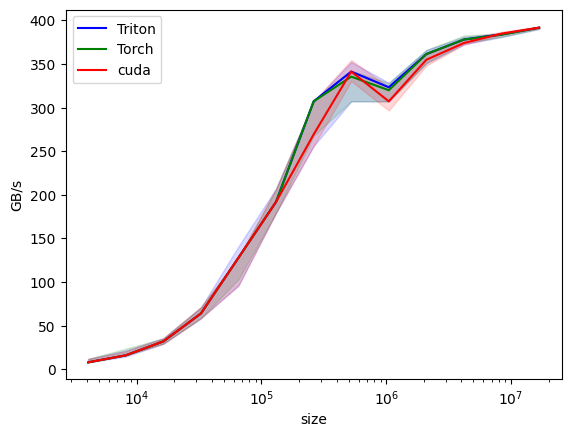

vector-add-performance:
          size      Triton       Torch        cuda
0       4096.0    8.000000    8.000000    8.000000
1       8192.0   15.999999   15.999999   15.999999
2      16384.0   31.999999   31.999999   31.999999
3      32768.0   63.999998   63.999998   63.999998
4      65536.0  127.999995  127.999995  127.999995
5     131072.0  192.000000  192.000000  192.000000
6     262144.0  307.200008  307.200008  269.326017
7     524288.0  341.333321  335.508544  341.333321
8    1048576.0  323.368435  319.947929  307.200008
9    2097152.0  361.411758  361.411758  354.888069
10   4194304.0  378.092307  378.092307  374.090617
11   8388608.0  384.000001  383.625364  384.869141
12  16777216.0  391.649417  391.649417  391.649417


In [88]:
benchmark.run(print_data=True, show_plots=True)

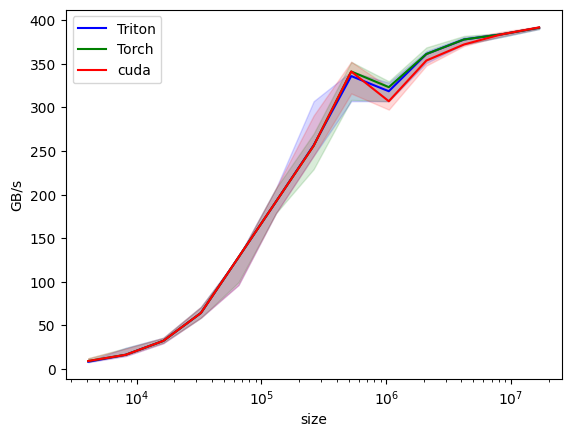

vector-add-performance:
          size      Triton       Torch        cuda
0       4096.0    8.000000    8.827586    8.827586
1       8192.0   15.999999   15.999999   15.999999
2      16384.0   31.999999   31.999999   31.999999
3      32768.0   63.999998   63.999998   63.999998
4      65536.0  127.999995  127.999995  127.999995
5     131072.0  192.000000  192.000000  192.000000
6     262144.0  256.668403  255.999991  255.999991
7     524288.0  336.082050  341.333321  341.333321
8    1048576.0  318.651548  323.368435  307.200008
9    2097152.0  361.411758  361.411758  353.929805
10   4194304.0  378.092307  378.092307  372.363633
11   8388608.0  384.000001  384.000001  384.000001
12  16777216.0  391.649417  391.649417  391.966607


In [90]:
benchmark.run(print_data=True, show_plots=True)

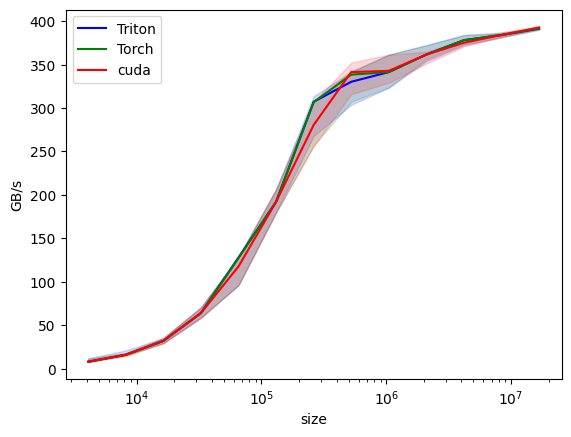

vector-add-performance:
          size      Triton       Torch        cuda
0       4096.0    8.041885    8.000000    8.000000
1       8192.0   15.999999   15.999999   15.999999
2      16384.0   31.999999   31.999999   31.999999
3      32768.0   63.999998   63.999998   63.999998
4      65536.0  127.999995  127.336788  117.588514
5     131072.0  192.000000  192.000000  192.000000
6     262144.0  307.200008  306.720753  280.467898
7     524288.0  330.156174  338.395869  341.333321
8    1048576.0  341.333321  341.333321  342.821272
9    2097152.0  361.577926  361.577926  361.411758
10   4194304.0  378.092307  378.092307  375.116620
11   8388608.0  384.000001  384.000001  384.023446
12  16777216.0  391.235377  391.625032  392.798670


In [6]:
benchmark.run(print_data=True, show_plots=True)

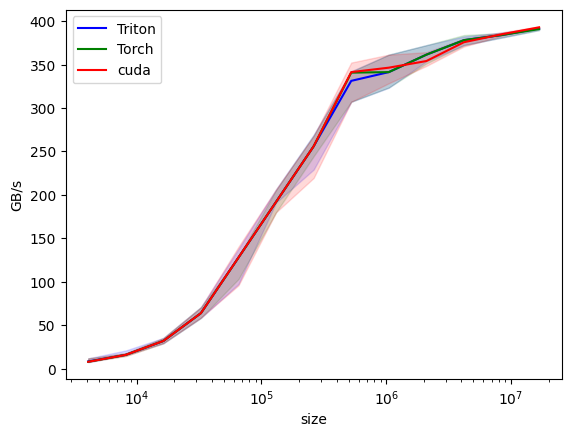

vector-add-performance:
          size      Triton       Torch        cuda
0       4096.0    8.416438    8.020888    8.000000
1       8192.0   15.999999   15.999999   15.999999
2      16384.0   31.999999   31.999999   31.999999
3      32768.0   63.999998   63.999998   63.999998
4      65536.0  127.999995  127.999995  127.999995
5     131072.0  192.000000  192.000000  192.000000
6     262144.0  255.999991  255.999991  255.999991
7     524288.0  331.268756  340.741751  341.333321
8    1048576.0  341.333321  341.333321  346.445807
9    2097152.0  361.411758  361.411758  354.089163
10   4194304.0  378.092307  378.092307  375.743910
11   8388608.0  384.000001  383.976559  384.822070
12  16777216.0  391.625032  390.870784  392.872227


In [ ]:
benchmark.run(print_data=True, show_plots=True)